In [1]:
%config InlineBackend.figure_format = "svg"

# Import models and data splitting from sktime
from sktime.forecasting.model_selection import SlidingWindowSplitter
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.series.detrend import Detrender
from sktime.transformations.series.impute import Imputer
from sktime.forecasting.naive import NaiveForecaster

# Import metrics
from sktime.performance_metrics.forecasting import MeanAbsoluteError

# Silence warnings
import warnings
warnings.filterwarnings('ignore')

# Data acquisition and processing tools
from tqdm import tqdm
import pandas as pd
import numpy as np

## Loading data

After loading the data, we must set the dates to a `pandas` `PeriodIndex` format for it to be compatible with `sktime`:

In [2]:
datapath = "data/train.csv"
df = pd.read_csv(datapath, index_col="date")
df = df.set_index(pd.PeriodIndex(df.index, freq="D").to_timestamp()).to_period("D")
df

,tavg,tmin,tmax,wdir,wspd,pres
date,,,,,,
2018-01-01,3.1,0.6,5.4,48.0,6.5,1011.7
2018-01-02,5.0,2.3,7.7,335.0,11.4,1009.5
2018-01-03,4.0,0.7,6.6,223.0,12.2,1007.9
2018-01-04,4.7,2.2,10.4,190.0,8.0,1005.8
2018-01-05,6.4,3.7,9.5,144.0,6.3,1007.3
...,...,...,...,...,...,...
2022-09-23,12.0,6.8,17.3,300.0,5.3,1020.6
2022-09-24,12.2,5.5,18.2,98.0,8.3,1017.7
2022-09-25,13.7,11.0,16.5,73.0,6.1,1014.5


## Creating pipeline

As we saw already in the exploratory data analysis notebook, there are two steps needed for preprocessing our data:
- Linear interpolation for handling missing values
- Classical decomposition

First, let's create our linear interpolator and check that it works:

In [3]:
interpolator = Imputer(method="linear")
inter_df = interpolator.fit_transform(df)
inter_df.isna().sum()

tavg    0
tmin    0
tmax    0
wdir    0
wspd    0
pres    0
dtype: int64

Now let's create our detrender so that we only use a model for only predicting on the seasonal component of the time series:

<AxesSubplot: xlabel='date'>

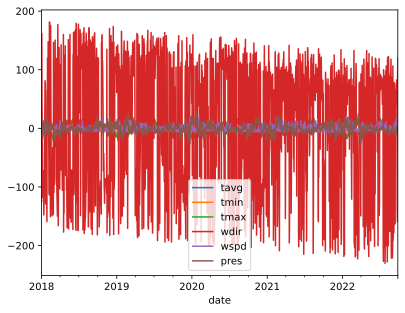

In [4]:
detrender = Detrender()
detrender.fit_transform(inter_df).plot()

As we can see, we are left with only the seasonal component of our time-series!

For this forecasting problem, we will be using the naive method for seasonal forecasting:
- Naive seasonal method forecasts using the corresponding value of the previous period

In [5]:
#Create forecaster
forecaster = NaiveForecaster(strategy="last", sp=365)

# Create seasonal pipeline
pipeline = TransformedTargetForecaster(steps=[
    ("interpolator", interpolator),
    ("detrender", detrender),
    ("forecaster", forecaster)
])
pipeline

TransformedTargetForecaster(steps=[('interpolator', Imputer(method='linear')),
                                   ('detrender', Detrender()),
                                   ('forecaster', NaiveForecaster(sp=365))])

## Training our model

Now let's evaluate this forecaster using cross validation! We will use the Mean Absolute Error metric, which is defined as the mean of the absolute value of the residuals:
$$ MAE = \frac{1}{N} \sum_{i=1}^{N} \left| y_{T+i} - \hat{y}_{T+i} \right| $$

In [6]:
# Creating Validation folds
nfolds = 5
forecast_size = 14
fh = np.arange(forecast_size) + 1
window_length = df.shape[0] - nfolds - forecast_size + 1
splitter = list(SlidingWindowSplitter(fh=fh, window_length=window_length).split(df))

# Iterate folds
metric = MeanAbsoluteError(multioutput="raw_values")
train_score, val_score = 0, 0
bar = tqdm(splitter, desc="Cross-validating")
for train_idx, val_idx in bar:
    
    # Get train and validation data (interpolate for avoiding NaN in metric calculation)
    y_train, y_val = df.iloc[train_idx].interpolate(method="linear"), df.iloc[val_idx].interpolate(method="linear")
    
    # Get training performance
    forecaster = pipeline.fit(y_train.iloc[:-forecast_size], fh=fh)
    y_train_pred = pipeline.predict()
    train_score += metric(y_train.iloc[-forecast_size:], y_train_pred) / len(splitter)
    
    # Predict on validation data
    forecaster = pipeline.fit(y_train, fh=fh)
    y_val_pred = pipeline.predict()
    val_score += metric(y_val, y_val_pred) / len(splitter)

Cross-validating: 100%|██████████| 5/5 [00:20<00:00,  4.01s/it]


In [7]:
train_score = pd.DataFrame(data=train_score.reshape(1, -1), index=[0], columns=y_val.columns)
train_score

,tavg,tmin,tmax,wdir,wspd,pres
0,2.545066,3.253243,3.314712,157.499229,5.150047,4.894043


In [8]:
val_score = pd.DataFrame(data=val_score.reshape(1, -1), index=[0], columns=y_val.columns)
val_score

,tavg,tmin,tmax,wdir,wspd,pres
0,3.887175,3.158829,5.079269,74.975853,6.31007,4.350094
